# Convolutional Neural Networks

In this lab, you will look at convolutional neural networks, and compare it with standard feedforward neural networks when handling certain types of structured data, such as images.

## Preparation

We will start by importing the libraries that we will use throughout. Most of these you encountered in the previous lab, already.

In [1]:
# Numpy library provides useful numeric computation utilities
import numpy as np

# We import Pyplot for its plotting utilities
import matplotlib.pyplot as plt

# We import torch, torch.nn and torchvision, since these provide the neural 
# network and image processing utilities we will use
import torch
import torch.nn as nn
import torchvision

# We also import the functional module of torch.nn, since it has some useful 
# functions implemented in Pytorch
import torch.nn.functional as F

# torchvision.transforms is used to load images into adequate Pytorch tensors.
# It also provides some potentially useful utilities to transform images (more 
# on this later).
import torchvision.transforms as transforms

We will again use the FashionMNIST dataset, which you encountered in the previous lab:

![<Image not loaded>](https://miro.medium.com/max/1400/1*RCXpLibVCgoRYckEd2kU8Q.png)

Recall that FashionMNIST consists of a dataset of 60,000 training images and 10,000 test images. Each example is a 28&times;28 grayscale image, associated with a label from 10 classes, corresponding to a piece of clothing:

| Label   |  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 
| ------- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Object  | T-shirt | Trousers | Pull-over | Dress | Coat | Sandal | Shirt | Sneaker | Bag | Boot |

We start by loading the dataset and then creating the associated dataloaders, which will be used to sample batches of images during training. However, unlike in the previous lab, we will now be careful to normalize the data, since this helps in training.

In [2]:
# The images, once loaded, are transformed in two ways: 
#  - They are turned to tensors
#  - They are normalized

# We construct a "transformator" to perform those two things.
transformator = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# We can now import the training and test data
train_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=transformator)

valid_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=False,
                                              transform=transformator)

# We now create our dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=10000)

In [3]:
a = train_set[0]
type(a[1])
a = next(iter(train_loader))
b = a[1]
b[0]
torch.tensor([2])

tensor([2])

To make our life easier further ahead, we create an auxiliary function to evaluate a network given a batch of data and a loss function. The is called `evaluate` and receives, as arguments,

* The neural network
* The input batch
* The output batch
* The loss function

The function returns both the loss and the accuracy of the network in the batch.

In [5]:
def evaluate(net, Xbatch, ybatch, loss):
  
    # Compute batch size
    batch_size = Xbatch.size(0)

    # We first set the network to "evaluation mode". This is useful, for 
    # example, in dropout layers, which should behave differently in training 
    # and evaluation.
    net.eval()

    # We compute both scores and labels
    outputs = net(Xbatch)
    _, labels = torch.max(outputs, dim=1)

    # Compute loss
    l = loss(outputs, ybatch).item()

    # Compute accuracy
    acc = torch.sum(labels == ybatch.data).double().item() / batch_size
    
    # We reset the network back to training mode
    net.train()
    
    return l, acc

We also define a general function to be used when training a neural network. We call the function `train_network`. The function shall receive, as arguments:

* The neural network
* The loss function
* The optimizer
* The training data loader

We'll also include an optional parameter to specify the number of epochs (we'll use 20 as the default value).

In [6]:
def train_network(net, loss, optimizer, dataloader, num_epochs=20):
    
    # We start by initializing two lists, to track the loss and accuracy during
    # training.
    train_losses = []
    train_accuracies = []

    valid_losses = []
    valid_accuracies = []

    for ep in range(num_epochs):
        print('\n- Training epoch: %i -' % ep)

        # We use auxiliary variables to keep track of loss and accuracy within 
        # an epoch
        running_loss = 0.
        running_acc  = 0.
        dataset_size = 0

        for Xbatch, ybatch in dataloader:
            batch_size = Xbatch.size(0)
            dataset_size += batch_size
            
            # We zero-out the gradient
            optimizer.zero_grad()

            # Compute output
            outputs = net(Xbatch)

            # Our outputs are *scores*, so we also compute the predicted labels, 
            # since we need them to check the accuracy
            #
            # To that purpose, we compute the class that maximizes the score. 
            # The max function returns both the maximum value, and the 
            # maximizing entry. We care only about the latter, so we ignore the 
            # first output. 
            #
            # Also, recall that the dimensions of the output are 
            # (batch size, n. classes). We take the maximum over the first 
            # dimension
            _, labels = torch.max(outputs, dim=1)

            # Get loss
            l = loss(outputs, ybatch)

            # Compute gradient
            l.backward()
            
            # Perform optimization step
            optimizer.step()

            # Update total running loss. We account for the number of points 
            # in the batch
            running_loss += l.item() * batch_size
             
            # Update the accuracy
            running_acc += torch.sum(labels == ybatch.data).double().item()

        train_losses += [running_loss / dataset_size]
        train_accuracies += [running_acc / dataset_size]

        # Loss and accuracy in the validation set
        val_x, val_y = next(iter(valid_loader))
        with torch.no_grad():
            aux_l, aux_a = evaluate(net, val_x, val_y, loss)

        valid_losses += [aux_l]
        valid_accuracies += [aux_a]

        print(f'Training loss: {train_losses[-1]:.4f}')
        print(f'Training accuracy: {train_accuracies[-1]:.1%}')
        print(f'Validation loss: {valid_losses[-1]:.4f}')
        print(f'Validation accuracy: {valid_accuracies[-1]:.1%}')

    return net, train_losses, train_accuracies, valid_losses, valid_accuracies

## Creating a feed-forward neural network

As a baseline for comparison, we create a standard feedforward neural network, much like the one from the previous lab. To that purpose, we create a class `FeedForwardNetwork` similar to the one from last week, but now make it a little more flexible, to enable easily changing the size of the network.

In [7]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, input_size, layers, output_size):
        ''' The layers parameter is a list containing the number of units in 
            each layer of the network. The number of elements in the list 
            corresponds to the number of layers in the network.'''

        # As in last week's architecture, we start by calling the constructor 
        # of the parent class
        super().__init__()
        
        # Since we now have a varying number of layers, we cannot use 
        # Sequential -- we instead use ModuleList. ModuleList is just like a 
        # list, but aware that there are nn.Modules inside.
        
        # We start by creating a regular list of layers that we then pass as
        # argument to ModuleList. Our first layer is a Flatten layer, to turn
        # the images into vectors.
        
        layer_list = [nn.Flatten()]
        for i in range(len(layers)):
            if i == 0:
                input_dim = input_size
            else:
                input_dim = layers[i-1]

            output_dim = layers[i]
            layer_list += [nn.Linear(input_dim, output_dim), nn.ReLU()]

        # We add one final output layer
        layer_list += [nn.Linear(layers[-1], output_size)]

        # We can now create our module list
        self.layers = nn.ModuleList(layer_list)

    def forward(self, x):
        # Since we do not use Sequential, we must now perform the forward 
        # propagation of information "by hand"
        
        # We create an "input layer" by setting
        h = x

        # We now run through the layers, using as input the output of the 
        # previous one
        for layer in self.layers:
            h = layer(h)

        return h

## Training our neural network

We now train our neural network on the FashionMNIST dataset. The process is, in all aspects, similar to the one from last week's lab, and is abstracted into the function `train_network` defined above. We have only to define the loss and optimizer.

In [9]:
# We create a network with two hidden layers of 200 units each
two_layer_net_1 = FeedForwardNetwork(28 * 28, [200, 200], 10)

# We use the cross-entropy loss
loss = nn.CrossEntropyLoss()

# ... and stochastic gradient descent as the optimizer
sgd = torch.optim.Adam(two_layer_net_1.parameters(), lr=0.01)

two_layer_net_1, sgd_lss_trn, sgd_acc_trn, sgd_lss_vld, sgd_acc_vld = train_network(two_layer_net_1, loss, sgd, train_loader, 5)


- Training epoch: 0 -
Training loss: 0.5694
Training accuracy: 80.0%
Validation loss: 0.4942
Validation accuracy: 82.7%

- Training epoch: 1 -
Training loss: 0.4509
Training accuracy: 84.2%
Validation loss: 0.4385
Validation accuracy: 84.3%

- Training epoch: 2 -
Training loss: 0.4216
Training accuracy: 85.3%
Validation loss: 0.4481
Validation accuracy: 83.8%

- Training epoch: 3 -
Training loss: 0.4111
Training accuracy: 85.7%
Validation loss: 0.4371
Validation accuracy: 85.0%

- Training epoch: 4 -
Training loss: 0.4043
Training accuracy: 85.8%
Validation loss: 0.4574
Validation accuracy: 84.6%


We can plot the accuracy and loss during training, and see how they evolve.

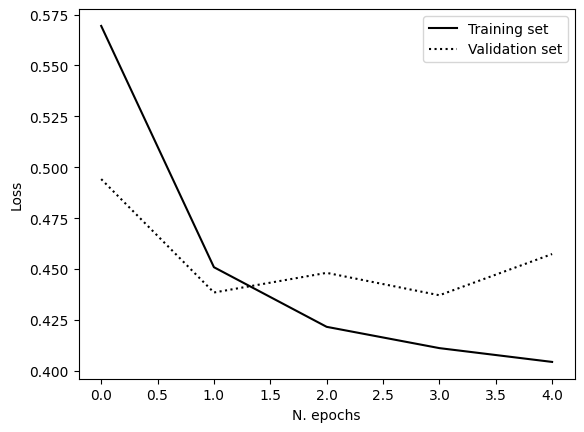

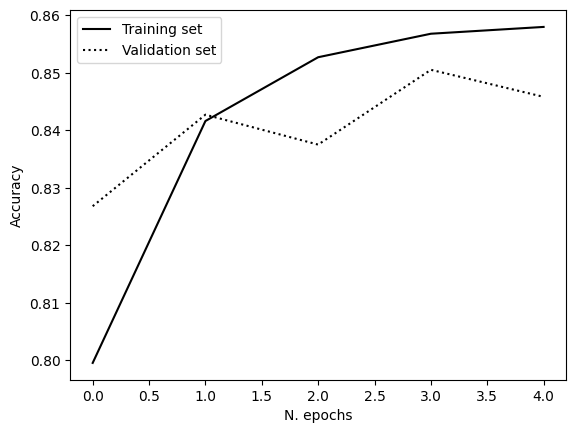

In [10]:
plt.figure()
plt.plot(sgd_lss_trn, 'k-', label='Training set')
plt.plot(sgd_lss_vld, 'k:', label='Validation set')
plt.xlabel('N. epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(sgd_acc_trn, 'k-', label='Training set')
plt.plot(sgd_acc_vld, 'k:', label='Validation set')
plt.xlabel('N. epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

## Trying other optimizers

Let's now try different ways of optimizing our neural network. In particular, let's see if we do any better using stochastic gradient descent with momentum.

In [11]:
# Another (similar) network
two_layer_net_2 = FeedForwardNetwork(28 * 28, [200, 200], 10)

# We add momentum to the optimizer
sgd_momentum = torch.optim.SGD(two_layer_net_2.parameters(), lr=0.01, momentum=0.5)

two_layer_net_2, mom_lss_trn, mom_acc_trn, mom_lss_vld, mom_acc_vld = train_network(two_layer_net_2, loss, sgd_momentum, train_loader, 5)


- Training epoch: 0 -
Training loss: 0.7697
Training accuracy: 74.2%
Validation loss: 0.5482
Validation accuracy: 80.2%

- Training epoch: 1 -
Training loss: 0.4707
Training accuracy: 83.2%
Validation loss: 0.4704
Validation accuracy: 83.0%

- Training epoch: 2 -
Training loss: 0.4238
Training accuracy: 84.8%
Validation loss: 0.4437
Validation accuracy: 84.0%

- Training epoch: 3 -
Training loss: 0.3961
Training accuracy: 85.8%
Validation loss: 0.4244
Validation accuracy: 84.6%

- Training epoch: 4 -
Training loss: 0.3735
Training accuracy: 86.5%
Validation loss: 0.4193
Validation accuracy: 85.0%


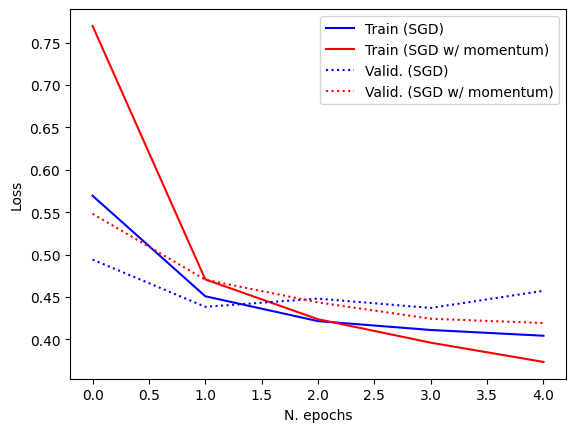

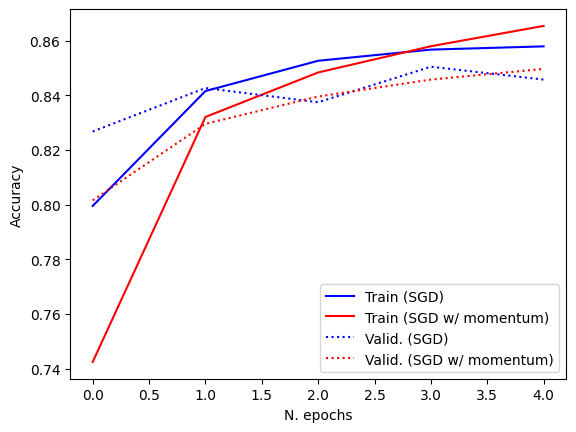

In [12]:
plt.figure()
plt.plot(sgd_lss_trn, 'b-', label='Train (SGD)')
plt.plot(mom_lss_trn, 'r-', label='Train (SGD w/ momentum)')
plt.plot(sgd_lss_vld, 'b:', label='Valid. (SGD)')
plt.plot(mom_lss_vld, 'r:', label='Valid. (SGD w/ momentum)')
plt.xlabel('N. epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(sgd_acc_trn, 'b-', label='Train (SGD)')
plt.plot(mom_acc_trn, 'r-', label='Train (SGD w/ momentum)')
plt.plot(sgd_acc_vld, 'b:', label='Valid. (SGD)')
plt.plot(mom_acc_vld, 'r:', label='Valid. (SGD w/ momentum)')
plt.xlabel('N. epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

## Creating a convolutional neural network

We now create a convolutional neural network to process precisely the same dataset. To that purpose, we create a class `ConvolutionalNetwork` containing two convolutional layers and a single fully connected layer.

In [13]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, ):

        # As before, we call the constructor of the parent class
        super().__init__()
        
        # Since the architecture is fixed, we can easily use the Sequential 
        # module to define our architecture.
        self.layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),    # 1 channel in, 10 out
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),   # 10 channels in, 20 out
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Linear(50, 10))
    
    def forward(self, x):
        return self.layers(x)

## Training our CNN

We now train our CNN, just as we trained the previous nets. We use Adam as our optimizer.

In [14]:
conv_net = ConvolutionalNetwork()

adam_conv = torch.optim.Adam(conv_net.parameters(), lr=0.001)

conv_net, conv_lss_trn, conv_acc_trn, conv_lss_vld, conv_acc_vld = train_network(conv_net, loss, adam_conv, train_loader, 5)


- Training epoch: 0 -
Training loss: 0.5756
Training accuracy: 79.0%
Validation loss: 0.4200
Validation accuracy: 84.9%

- Training epoch: 1 -
Training loss: 0.3812
Training accuracy: 86.2%
Validation loss: 0.3938
Validation accuracy: 85.9%

- Training epoch: 2 -
Training loss: 0.3293
Training accuracy: 88.0%
Validation loss: 0.3509
Validation accuracy: 87.6%

- Training epoch: 3 -
Training loss: 0.3021
Training accuracy: 89.1%
Validation loss: 0.3340
Validation accuracy: 88.2%

- Training epoch: 4 -
Training loss: 0.2829
Training accuracy: 89.8%
Validation loss: 0.3276
Validation accuracy: 88.4%


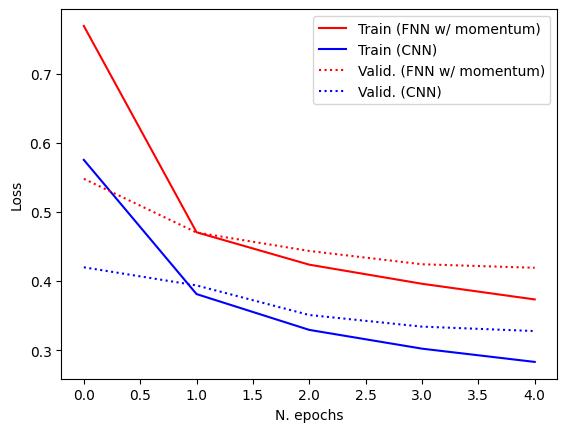

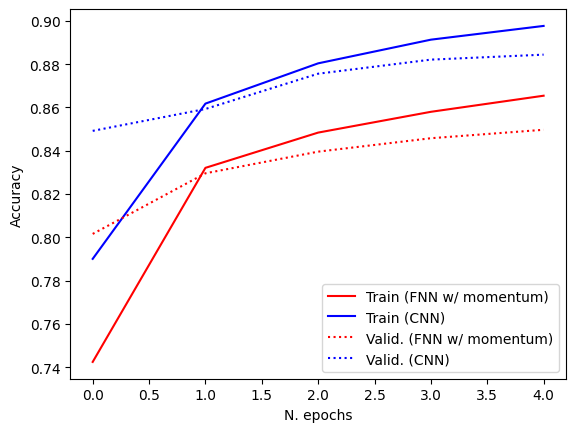

In [15]:
plt.figure()
plt.plot(mom_lss_trn, 'r-', label='Train (FNN w/ momentum)')
plt.plot(conv_lss_trn, 'b-', label='Train (CNN)')
plt.plot(mom_lss_vld, 'r:', label='Valid. (FNN w/ momentum)')
plt.plot(conv_lss_vld, 'b:', label='Valid. (CNN)')
plt.xlabel('N. epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(mom_acc_trn, 'r-', label='Train (FNN w/ momentum)')
plt.plot(conv_acc_trn, 'b-', label='Train (CNN)')
plt.plot(mom_acc_vld, 'r:', label='Valid. (FNN w/ momentum)')
plt.plot(conv_acc_vld, 'b:', label='Valid. (CNN)')
plt.xlabel('N. epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Activities

1. How many parameters does the "vanilla" feedforward network have? And how many parameters does the CNN have?

2. Why does the CNN outperform the "vanilla" feedforward network, even though it has a smaller number of parameters?

3. You will now test how both the feed forward network and the CNN handle images that are not centered. To that purpose, create a new data loader using the code snippet:
```
nasty_transformator = transforms.Compose(
      [transforms.ToTensor(),
       transforms.RandomAffine(0, translate=[0.1, 0]),
       transforms.Normalize((0.5,), (0.5,))])
nasty_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=False,
                                              transform=nasty_transformator)
nasty_loader = torch.utils.data.DataLoader(nasty_set, batch_size=10000)
```
and evaluate both networks in that set. What can you observe? Can you explain?